# Deep-Learning with Keras

#### Ugur URESIN, AI Engineer | Data Scientist
#### Mail: uresin.ugur@gmail.com

## Chapter 05. Neural Networks - Regression with Constraints
### Dataset: Randomly created  

**The Objective**  
Let's say that there are 2 control parameters of a machine (cp1 and cp2).  
We would like to find the best parameters to get minimum machining cost.  
However, we would not want to get the control parameters that machine works instable.  
Let's find how to constraint the neural network that finds the cost-optimum and stable parameters.  

### The Steps
* **Step01**. Creating a Dataset
* **Step02**. Partitioning the Dataset
* **Step03**. Normalizimg the Dataset
* **Step04**. Building the network architecture
* **Step05**. The compilation and Training
* **Step06**. Creating a Validation Log

### Step 01. Creating a Dataset

In [1]:
import numpy as np

In [2]:
## CREATING CONTROL PARAMETERS (WE WILL USE THESE NUMBERS AS INPUTS)
cp1 = np.arange(1,11)*100
cp2 = np.arange(1,4)

In [3]:
## COMBINING CONTROL PARAMETERS
cp_doe = np.column_stack( (np.repeat(cp1,len(cp2)), np.tile(cp2,len(cp1)) ))

In [4]:
## CREATING A COST DATA (Let's say cost = cp1 + cp2*150)
costs = np.zeros((cp_doe.shape[0] ))

for i in range(0,cp_doe.shape[0]):
    cost = cp_doe[i,0] + cp_doe[i,1]*150
    costs[i] = cost

In [5]:
### COMBINING ALL DATA
all_data = np.column_stack( (cp_doe,costs))
all_data[0:6,:]

array([[100.,   1., 250.],
       [100.,   2., 400.],
       [100.,   3., 550.],
       [200.,   1., 350.],
       [200.,   2., 500.],
       [200.,   3., 650.]])

### Step 02. Partitioning the Dataset

In [6]:
x = all_data
np.random.shuffle(x)
nrows = int(x.shape[0]*0.8)

train_data, test_data = x[:,0:2][:nrows,:], x[:,0:2][nrows:,:]
train_targets, test_targets = x[:,2][:nrows], x[:,2][nrows:]

In [7]:
print('Training data size: ', train_data.shape)
print('Test data size: ', test_data.shape)

Training data size:  (24, 2)
Test data size:  (6, 2)


In [8]:
print("Training Inputs:\n", train_data[0:3,:])
print("Training Targets:\n", train_targets[0:3])

Training Inputs:
 [[300.   2.]
 [400.   1.]
 [400.   2.]]
Training Targets:
 [600. 550. 700.]


In [9]:
print("Test Inputs:\n", test_data[0:3,:])
print("Test Targets:\n", test_targets[0:3])

Test Inputs:
 [[400.   3.]
 [800.   1.]
 [800.   3.]]
Test Targets:
 [ 850.  950. 1250.]


### Step 03. Normalizing the Dataset

#### Normalizing the datasets 

It would be problematic to feed into a neural network values that all take wildly different ranges.  
The network might be able to automatically adapt to such heterogeneous data, but it would definitely make learning more difficult.  
A widespread best practice to deal with such data is to do **feature-wise normalization**.  

For each feature in the input data (a column in the input data matrix),  
the mean of the feature is substracted and divided by the standard deviation,  
so that the feature is centered around 0 and has a unit standard deviation.

In [10]:
train_mean = train_data.mean(axis=0)
train_std = train_data.std(axis=0)

train_data -= train_mean
train_data /= train_std

test_data -= train_mean
test_data /= train_std

Note that the quantities used **for normalizing the test data** are computed **using the
training data**!!!  

<span style="color:red">
You should **never use any quantity computed on the test data!**  
    (Even for something as simple as data normalization)
</span>.

In [11]:
print("Normalized Train Data:\n", train_data[0:3,:])
print("Normalized Test Data:\n", test_data[0:3])

Normalized Train Data:
 [[-0.84051051  0.        ]
 [-0.48661135 -1.22474487]
 [-0.48661135  0.        ]]
Normalized Test Data:
 [[-0.48661135  1.22474487]
 [ 0.92898531 -1.22474487]
 [ 0.92898531  1.22474487]]


### Step04. Building the network architecture

In [12]:
from keras import models
from keras import layers

def build_model(ll1,ll2,train_data):
    model = models.Sequential()
    model.add(layers.Dense(ll1, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(ll2))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) #mae:mean-absolute-error
    return model

The network ends with a single unit and **no activation** (it will be a linear layer).   
This is a typical setup for scalar regression (a regression where you’re trying to predict a single continuous value).

A new metric is monitored during training: **mean absolute error** (MAE).   
It’s the absolute value of the difference between the predictions and the targets.  
For instance, an MAE of 0.5 on this problem would mean your predictions are off by $500 on average.

### Step05. The Compilation and Training

#### k-fold validation

![k-fold validation](./img/kfold_Validation.png "k-fold validation")

In [13]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i+1)
    
    #preparing the validation data, from k'th partition of the data
    val_data    = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    #preparing the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model(2,1, train_data)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


In [14]:
print("Scores: ", all_scores)
print("Mean score: ", np.mean(all_scores))

Scores:  [602.2775268554688, 969.14599609375, 726.7732543945312, 1030.7220458984375]
Mean score:  832.2297058105469


### Step06. Creation a Validation Log

In [15]:
num_epochs = 3000

all_mae_histories = []

for i in range(k):
    print('processing fold #', i+1)
    
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model(2,1,train_data)
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4


#### Building the history of successive mean K-fold validation scores

In [16]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

#### Plotting validation scores

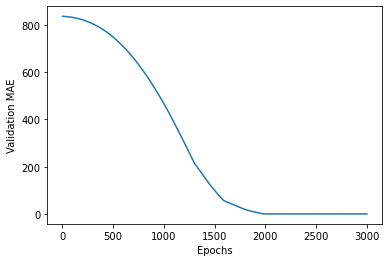

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Plotting validation scores, excluding the first 10 data points

In [18]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []

    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)

    return smoothed_points

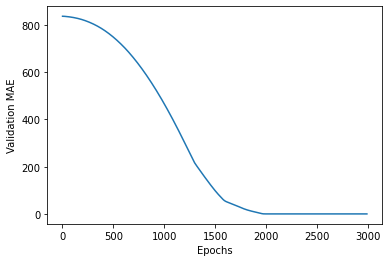

In [19]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

#### Making Predictions

In [20]:
# cp1=500, cp2=1
Xnew = np.array([500.0,1.0])

Xnormalized = Xnew - train_mean
Xnormalized /= train_std

Xnormalized

array([-0.13271219, -1.22474487])

In [21]:
Xnormalized = np.array([Xnormalized])

In [22]:
ynew = model.predict(Xnormalized)
ynew

array([[649.9533]], dtype=float32)

### Step07. Adding Constraint on the Last Layer

In [23]:
def build_model_wc(ll1,ll2,train_data):
    model_wc = models.Sequential()
    model_wc.add(layers.Dense(ll1, activation='relu', input_shape=(train_data.shape[1],)))
    model_wc.add(layers.Dense(ll2))
    model_cw.compile(optimizer='rmsprop', loss='mse', metrics=['mae']) #mae:mean-absolute-error
    return model

In [24]:
k = 4
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []

for i in range(k):
    print('processing fold #', i+1)
    
    #preparing the validation data, from k'th partition of the data
    val_data    = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    #preparing the training data: data from all other partitions
    partial_train_data = np.concatenate([train_data[:i * num_val_samples],
                                         train_data[(i + 1) * num_val_samples:]],
                                        axis=0)
    
    partial_train_targets = np.concatenate([train_targets[:i * num_val_samples],
                                            train_targets[(i + 1) * num_val_samples:]],
                                           axis=0)
    
    model = build_model(2,1, train_data)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
